# Washington_RPV_2020_Precincts_05_08_2023

## Background:
- We received a request for voter registration by party and voter turnout by primary contest (Republican and Democratic) for the 2022 Primary Election, voter turnout for the 2022 General Election, 2020 VAP by race/ethnicity, 2021 CVAP by race/ethnicity, 2020 Presidential and Gubernatorial contests, and 2022 Senate results on 2020 Precincts.

## Approach:
Voter file data was provided by L2. Voter file data is retrieved at the individual level and aggregated to 2020 precincts using a spatial join. Not all individuals are able to be aggregated as they do not all contain a latitude, longitude coordinate or contain inaccurate coordinates (i.e. not geocoded). There are 32 instances where the lat/long of a voter falls in potentially two precincts, to select the correct precinct we matched voter file-assigned precincts and counties to the 2020 precinct shapefile. Party registration data is modeled by L2 based entirely on academic modeling. Because voters can vote for candidates in any party, the primary voter turnout by party is based on the modeled registration (only 4 individuals appear to be an exception to this). Voter file data on 2020 precincts is then grouped by precinct assignment and joined with the precinct file containing 2020 election results.

2020 election results and precinct boundaries are provided by the [Voting Election and Science Team](https://dataverse.harvard.edu/file.xhtml?fileId=5007851&version=40.0).

2022 Senate election results were retrieved from the [Washington Secretary of State (SOS)](https://www.sos.wa.gov/elections/research/2022-general-election.aspx) and joined to the 2022 shapefile also retrieved from the [SOS](https://www.sos.wa.gov/elections/research/Precinct-Shapefiles.aspx). These data were disaggregated using a modified Voting Age Population (VAP) variable where the adult incarcerated population is removed to calculate data at the 2020 block level. The results differ by a total of 4 for Murray and match the official totals exactly for other candidates.

Other 2020 block level data include CVAP and VAP by race. The 2020 VAP data by race is readily provided by the Census in the PL 94-171 dataset. We used the "Alone" values where indicated above in the Fields section (a single variable in the PL data) and summed all respective columns including that race/ethnicity for those that are listed as "any part". 2021 CVAP data is provided by the Census at the block group level and the RDH has disaggregated this data to the block level using a racially-sensitive disaggregation to maintain racial distribution inside the block group. 

All 2020 block level data (2022 Senate, 2020 VAP, 2021 CVAP) was joined together on the GEOID20 field and assigned a "best fit" precinct using [maup](https://github.com/mggg/maup). These data were then grouped and summed by this assignment to then have all data (2020 election results, 2020 voter file, 2022 Senate results, 2020 VAP, and 2021 CVAP) on 2020 precinct shapes. Due to rounding differences, there can be up to a maximum of 4 (votes or people) fewer in the final file than in the inputs for a given column, for the entire state.

The data was checked for accuracy and exported as a CSV and SHP.

Please note that the 2021 CVAP data for CVAP_ASN21 and CVAP_AIA21 represent alone or in combination (Asian Alone + Asian and White, and Native American Alone + Native American and Black + Native American and White), which is slightly different than the VAP values, as those are represented as just "Alone". Moreover, the CVAP_BLK21 represents a sum of all available CVAP data (Black Alone + Black and White + Black and Native American) but the VAP data is more encompassing, including more fields as the PL data provides more racial categories. It is also to be noted that all CVAP data is Non-Hispanic, while in VAP it varies depending on the field (as noted in the description and column name).

For a 'raw-from-source' folder containing CVAP and PL data and 2020 and 2022 election results, contact info@redistrictingdatahub.org. Individual level voter file data cannot be provided.

Import necessary libraries

In [1]:
import os
import pandas as pd
import geopandas as gp
import maup
pd.set_option('display.max_columns', None)
wd = os.path.join(os.getcwd(),'raw-from-source')

Import all necessary datasets (voterfile at individual-level, CVAP at block-level, PL data at block-level, Senate 2022 results at block-level, and 2020 election results at 2020 precinct-level)

In [2]:
vf = pd.read_csv(os.path.join(wd,'wa_voter_data.csv'))
cvap = gp.read_file(os.path.join(os.path.join(wd,'wa_cvap_2021_2020_b'),'wa_cvap_2021_2020_b.shp'))
pl = pd.read_csv(os.path.join(os.path.join(wd,'wa_pl2020_b'),'wa_pl2020_b.csv'))
sen22 = gp.read_file(os.path.join(os.path.join(wd,'wa_2022_gen_2020_blocks'),'wa_2022_gen_2020_blocks.shp'))

prec = gp.read_file(os.path.join(os.path.join(wd,'wa_2020_clean'),'wa_2020_clean.shp'))
#Subset necessary columns for precinct 
prec = prec[['COUNTY', 'PRECCODE', 'COUNTYNAME', 'ST_CODE', 'PRECNAME', 'G20PREDBID', 'G20PRERTRU', 'G20PRELJOR', 'G20PREGHAW', 'G20PRESLAR', 'G20PRESKEN', 'G20PREOWRI', 'G20GOVDINS', 'G20GOVRCUL', 'G20GOVOWRI', 'geometry']]

C:\Users\SpencerNelson\AppData\Local\Temp\ipykernel_17152\3103163987.py:3: DtypeWarning: Columns (29,31,35,37,38,55) have mixed types. Specify dtype option on import or set low_memory=False.
  pl = pd.read_csv(os.path.join(os.path.join(wd,'wa_pl2020_b'),'wa_pl2020_b.csv'))


Make voterfile into point shapefile using lat/long coordinates and join spatial join to the 2020 precinct shapefile

In [3]:
vf['lat'] = vf['lat'].astype(float)
vf['lon'] = vf['lon'].astype(float)
points = gp.GeoDataFrame(vf,geometry = gp.points_from_xy(vf.lon, vf.lat, crs='EPSG:4326'))
points = points.to_crs(prec.crs)
joined = points.sjoin(prec,how='left')

Clean duplicate voters by giving them one assignment

In [4]:
joined['dup']= joined.duplicated(subset='lalvoterid')
dups = joined[joined['dup']==True]
dups_ids = list(dups['lalvoterid'].unique())
joined_sub_dups = joined[joined['lalvoterid'].isin(dups_ids)]
no_dups = joined[~joined['lalvoterid'].isin(dups_ids)]
rows = []
not_added_back = 0
for i in dups_ids:
    test = joined_sub_dups[joined_sub_dups['lalvoterid']==i]
    test['co_fips'] = test['co_fips'].apply(lambda x: str(x).zfill(3))
    test['COUNTY'] = test['COUNTY'].apply(lambda x: str(x)[2:5])
    test['match'] = test['co_fips'] == test['COUNTY']
    test_keep = test[test['match']==True]
    test_keep.drop(columns = 'match',inplace=True)
    if len(test_keep)==1:
        rows.append(test_keep)
    else:
        if len(test_keep)!=0:
            test_keep_prec= list(test_keep['ST_CODE'])[0]
            test_keep = test_keep[test_keep['ST_CODE']==test_keep_prec]
            rows.append(test_keep)
        else:
            not_added_back = not_added_back+1
print('Number of voters who had duplicate assignments: ', str(len(dups)))
print('Number of duplicate assignment voters not added back due to multiple poor assignments: ', not_added_back)
to_concat_back = gp.GeoDataFrame(pd.concat(rows),crs=joined.crs)
full = pd.concat([to_concat_back,no_dups])
if len(full)==len(points):
    print('All voters have one spatial assignment.')
else:
    print(len(points))
    print(len(full))
    main_list = list(set(points['lalvoterid']) - set(full['lalvoterid']))
    missing = (list(set(points['lalvoterid']).difference(full['lalvoterid'])))
    print(len(main_list))

C:\Users\SpencerNelson\anaconda3\envs\maup\lib\site-packages\geopandas\geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\SpencerNelson\anaconda3\envs\maup\lib\site-packages\geopandas\geodataframe.py:1472: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
C:\Users\SpencerNelson\AppData\Local\Temp\ipykernel_17152\946928587.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See

Number of voters who had duplicate assignments:  32
Number of duplicate assignment voters not added back due to multiple poor assignments:  0
All voters have one spatial assignment.


Remove voters with poor lat/long assignments (mismatched county assignment in voterfile and spatial join) and voters with no lat/long assignments

In [5]:
full['co_fips'] = full['co_fips'].apply(lambda x: str(x).zfill(3))
full['prec_fips']=full['COUNTY'].apply(lambda x: str(x)[2:5])
full['correct_county'] = full['co_fips'] == full['prec_fips']
joined_keep = full[full['correct_county']==True]
not_match = full[full['correct_county']==False]
print('Number of voters in the full file: ',str(len(full)))
print('Number of voters with block assignments that are not valid: ', str(len(not_match)))
not_match_w_assign = not_match[~not_match['prec_fips'].str.startswith('n')]
print('Number of voters with block assignments with incorrect precinct assignments after join (mistmatched county between voterfile and spatial assignment): ', str(len(not_match_w_assign)))
not_match_no_assign = not_match[not_match['prec_fips'].str.startswith('n')]
print('Number of voters with no precinct assignment at all (no lat/long or out-of-state): ', str(len(not_match_no_assign)))
print('Number of voters remaining: ' ,str(len(joined_keep)))

Number of voters in the full file:  4997283
Number of voters with block assignments that are not valid:  15113
Number of voters with block assignments with incorrect precinct assignments after join (mistmatched county between voterfile and spatial assignment):  448
Number of voters with no precinct assignment at all (no lat/long or out-of-state):  14665
Number of voters remaining:  4982170


Create pivot table for ballot type selected in the primary (REP or DEM) to aggregate data to 2020 precincts

In [6]:
joined_keep = joined_keep[['lalvoterid','parties_description','ball_type_prim','gen','ST_CODE']]
joined_keep['ball_type_prim'] = joined_keep['ball_type_prim'].fillna('No Primary Vote')
joined_keep['gen'] = joined_keep['gen'].fillna('No General Vote')
joined_keep['counts'] = 1
ball_type = joined_keep.pivot_table(index='ST_CODE',columns = ['ball_type_prim'],values=['counts'],aggfunc=sum)
ball_type.reset_index(drop=False,inplace=True)
ball_type.columns = ball_type.columns.droplevel(0)
ball_type.rename(columns = {ball_type.columns[0]:"ST_CODE",'D':'DEM_PRIM_VOTE22','R':'REP_PRIM_VOTE22','O':'OTH_PRIM_VOTE22'}, inplace = True)
ball_type.drop(columns = 'No Primary Vote',inplace=True)
display(ball_type.head())

ball_type_prim,ST_CODE,DEM_PRIM_VOTE22,OTH_PRIM_VOTE22,REP_PRIM_VOTE22
0,AD00000111,23.0,16.0,59.0
1,AD00000112,30.0,7.0,53.0
2,AD00000113,36.0,7.0,82.0
3,AD00000114,33.0,8.0,86.0
4,AD00000115,40.0,17.0,104.0


Create pivot table for modeled party registration to aggregate data to 2020 precincts

In [7]:
parties = joined_keep.pivot_table(index='ST_CODE',columns = ['parties_description'],values=['counts'],aggfunc=sum)
parties.reset_index(drop=False,inplace=True)
parties.columns = parties.columns.droplevel(0)
parties.rename(columns = {parties.columns[0]:"ST_CODE",'Democratic':'DEM_PRIM_REG22','Republican':'REP_PRIM_REG22','Non-Partisan':'NON_PRIM_REG22'}, inplace = True)
parties.head()

parties_description,ST_CODE,DEM_PRIM_REG22,NON_PRIM_REG22,REP_PRIM_REG22
0,AD00000111,59.0,77.0,88.0
1,AD00000112,65.0,44.0,96.0
2,AD00000113,75.0,59.0,132.0
3,AD00000114,70.0,50.0,124.0
4,AD00000115,65.0,45.0,158.0


Create pivot table for general election voter turnout to aggregate data to 2020 precincts

In [8]:
gen = joined_keep.pivot_table(index='ST_CODE',columns = ['gen'],values=['counts'],aggfunc=sum)
gen.reset_index(drop=False,inplace=True)
gen.columns = gen.columns.droplevel(0)
gen.rename(columns = {gen.columns[0]:"ST_CODE",'Y':'VOTED_GEN22'},inplace=True)
gen.drop(columns = 'No General Vote',inplace=True)
gen.head()

gen,ST_CODE,VOTED_GEN22
0,AD00000111,140.0
1,AD00000112,128.0
2,AD00000113,185.0
3,AD00000114,154.0
4,AD00000115,187.0


Join all pivot tables together 

In [9]:
joined_ball_type_parties = pd.merge(ball_type,parties,on='ST_CODE',how='outer',indicator=True)
print('Ballot type and registration join successful? ', str(len(joined_ball_type_parties[joined_ball_type_parties['_merge']!='both'])==0))
joined_ball_type_parties.drop(columns = '_merge',inplace=True)
joined_ball_type_parties.head()

Ballot type and registration join successful?  True


,ST_CODE,DEM_PRIM_VOTE22,OTH_PRIM_VOTE22,REP_PRIM_VOTE22,DEM_PRIM_REG22,NON_PRIM_REG22,REP_PRIM_REG22
0,AD00000111,23.0,16.0,59.0,59.0,77.0,88.0
1,AD00000112,30.0,7.0,53.0,65.0,44.0,96.0
2,AD00000113,36.0,7.0,82.0,75.0,59.0,132.0
3,AD00000114,33.0,8.0,86.0,70.0,50.0,124.0
4,AD00000115,40.0,17.0,104.0,65.0,45.0,158.0


In [10]:
joined_all_vf= pd.merge(joined_ball_type_parties,gen,on='ST_CODE',how='outer',indicator=True)
print('All voterfile at precinct level join successful? ', str(len(joined_all_vf[joined_all_vf['_merge']!='both'])==0))
joined_all_vf.drop(columns = '_merge',inplace=True)
joined_all_vf.head()

All voterfile at precinct level join successful?  True


,ST_CODE,DEM_PRIM_VOTE22,OTH_PRIM_VOTE22,REP_PRIM_VOTE22,DEM_PRIM_REG22,NON_PRIM_REG22,REP_PRIM_REG22,VOTED_GEN22
0,AD00000111,23.0,16.0,59.0,59.0,77.0,88.0,140.0
1,AD00000112,30.0,7.0,53.0,65.0,44.0,96.0,128.0
2,AD00000113,36.0,7.0,82.0,75.0,59.0,132.0,185.0
3,AD00000114,33.0,8.0,86.0,70.0,50.0,124.0,154.0
4,AD00000115,40.0,17.0,104.0,65.0,45.0,158.0,187.0


Join all pivoted voter file data with election data on 2020 precincts

In [11]:
joined_all_precinct = pd.merge(prec,joined_all_vf,on='ST_CODE',how='outer',indicator=False)
vf_cols = list(joined_all_vf.columns)
for i in vf_cols:
    joined_all_precinct[i].fillna(0.0)
joined_all_precinct.head()

,COUNTY,PRECCODE,COUNTYNAME,ST_CODE,PRECNAME,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREGHAW,G20PRESLAR,G20PRESKEN,G20PREOWRI,G20GOVDINS,G20GOVRCUL,G20GOVOWRI,geometry,DEM_PRIM_VOTE22,OTH_PRIM_VOTE22,REP_PRIM_VOTE22,DEM_PRIM_REG22,NON_PRIM_REG22,REP_PRIM_REG22,VOTED_GEN22
0,53057,406,Skagit,SK00000406,SEDRO WOOLLEY 6,328,428,14,6,2,4,8,301,480,1,"POLYGON ((-13605792.679 6189500.637, -13605792...",156.0,19.0,144.0,466.0,253.0,311.0,545.0
1,53057,330,Skagit,SK00000330,MOUNT VERNON 30,546,444,23,3,1,0,5,529,484,3,"POLYGON ((-13612918.852 6176600.180, -13612909...",256.0,37.0,170.0,595.0,226.0,372.0,739.0
2,53061,10154387,Snohomish,SN10154387,BOSTIAN,252,154,10,0,0,0,6,244,178,0,"POLYGON ((-13597357.939 6074455.831, -13596946...",106.0,10.0,59.0,261.0,108.0,136.0,353.0
3,53061,10154310,Snohomish,SN10154310,PARADISE,330,364,22,2,1,0,9,304,416,1,"POLYGON ((-13589538.281 6075605.618, -13589538...",152.0,20.0,150.0,360.0,160.0,323.0,572.0
4,53061,10154178,Snohomish,SN10154178,BEECHER,356,326,17,4,0,0,8,320,388,4,"POLYGON ((-13591366.966 6082842.238, -13591356...",154.0,31.0,141.0,369.0,166.0,278.0,548.0


Check number of voters who are omitted in the aggregated data due to no lat/long or poor lat/long

In [12]:
print('Original number of registered voters in L2 file: ', str(len(vf)))
all_reg_agg = joined_all_precinct['DEM_PRIM_REG22'].sum()+ joined_all_precinct['REP_PRIM_REG22'].sum()+ joined_all_precinct['NON_PRIM_REG22'].sum()
print('Number of registered voters that get aggregated to precincts: ', str(all_reg_agg))
print('Number of registered voters in L2 file that did not get aggregated to precincts: ', str(len(vf)-all_reg_agg))

Original number of registered voters in L2 file:  4997283
Number of registered voters that get aggregated to precincts:  4982170.0
Number of registered voters in L2 file that did not get aggregated to precincts:  15113.0


In [13]:
original_rep_prim_voters = len(vf[vf['ball_type_prim']=='R'])
rep_voters_agg = joined_all_precinct['REP_PRIM_VOTE22'].sum()

In [14]:
print('Original number of Republican primary voters in L2 file: ', str(original_rep_prim_voters))
print('Number of Republican primary voters that get aggregated to precincts: ', str(rep_voters_agg))
print('Number of Republican primary voters in L2 file that did not get aggregated to precincts: ', str(original_rep_prim_voters-rep_voters_agg))

Original number of Republican primary voters in L2 file:  671501
Number of Republican primary voters that get aggregated to precincts:  669210.0
Number of Republican primary voters in L2 file that did not get aggregated to precincts:  2291.0


In [15]:
original_dem_prim_voters = len(vf[vf['ball_type_prim']=='D'])
dem_voters_agg = joined_all_precinct['DEM_PRIM_VOTE22'].sum()

In [16]:
print('Original number of Democractic primary voters in L2 file: ', str(original_dem_prim_voters))
print('Number of Democratic primary voters that get aggregated to precincts: ', str(dem_voters_agg))
print('Number of Democratic primary voters in L2 file that did not get aggregated to precincts: ', str(original_dem_prim_voters-dem_voters_agg))

Original number of Democractic primary voters in L2 file:  1081935
Number of Democratic primary voters that get aggregated to precincts:  1078917.0
Number of Democratic primary voters in L2 file that did not get aggregated to precincts:  3018.0


In [17]:
original_gen_voters = len(vf[vf['gen']=='Y'])
gen_voters_agg = joined_all_precinct['VOTED_GEN22'].sum()

In [18]:
print('Original number of general election voters in L2 file: ', str(original_gen_voters))
print('Number of general election voters that get aggregated to precincts: ', str(gen_voters_agg))
print('Number of general election voters in L2 file that did not get aggregated to precincts: ', str(original_gen_voters-gen_voters_agg))

Original number of general election voters in L2 file:  3023246
Number of general election voters that get aggregated to precincts:  3014303.0
Number of general election voters in L2 file that did not get aggregated to precincts:  8943.0


Query out necessary PL fields and sum where necessary

In [19]:
any_part_black_cols = ['P0030004', 'P0030011', 'P0030016', 'P0030017', 'P0030018', 'P0030019', 'P0030027', 'P0030028', 'P0030029', 'P0030030', 'P0030037', 'P0030038', 'P0030039', 'P0030040', 'P0030041', 'P0030042', 'P0030048', 'P0030049', 'P0030050', 'P0030051', 'P0030052', 'P0030053', 'P0030058', 'P0030059', 'P0030060', 'P0030061', 'P0030064', 'P0030065', 'P0030066', 'P0030067', 'P0030069', 'P0030071']
any_part_nhsp_black_cols = ['P0040006', 'P0040013', 'P0040018', 'P0040019', 'P0040020', 'P0040021', 'P0040029', 'P0040030', 'P0040031', 'P0040032', 'P0040039', 'P0040040', 'P0040041', 'P0040042', 'P0040043', 'P0040044', 'P0040050', 'P0040051', 'P0040052', 'P0040053', 'P0040054', 'P0040055', 'P0040060', 'P0040061', 'P0040062', 'P0040063', 'P0040066', 'P0040067', 'P0040068', 'P0040069', 'P0040071', 'P0040073']
pl_cols_to_keep = ['GEOCODE','P0010001','P0030001','P0040005','P0040007','P0040008','P0040009','P0040010','P0030008','P0040002']
to_query = pl_cols_to_keep+any_part_black_cols+any_part_nhsp_black_cols
pl['GEOCODE'] = pl['GEOCODE'].apply(lambda x: str(x).zfill(15))
pl_queried = pl[to_query]
pl_queried['ANY_PART_BLK_NHSP_VAP'] = pl_queried[any_part_nhsp_black_cols].sum(axis=1)
pl_queried['ANY_PART_BLK_VAP'] = pl_queried[any_part_black_cols].sum(axis=1)
pl_cols_to_keep = pl_cols_to_keep+['ANY_PART_BLK_NHSP_VAP','ANY_PART_BLK_VAP']
pl_queried2 = pl_queried[pl_cols_to_keep]
pl_queried2.rename(columns = {'GEOCODE':'GEOID20','P0010001':'TOTAL_POP','P0030001':'TOTAL_VAP','P0040005':'WHT_NHSP_VAP','P0040007':'AIAN_NHSP_VAP','P0040008':'ASN_NHSP_VAP','P0040009':'NHOPI_NHSP_VAP','P0040010':'OTH_NHSP_VAP','P0030008':'OTH_HISP_VAP','P0040002':'HISP_VAP'},inplace=True)
pl_queried2.head()

C:\Users\SpencerNelson\AppData\Local\Temp\ipykernel_17152\1985261131.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pl_queried['ANY_PART_BLK_NHSP_VAP'] = pl_queried[any_part_nhsp_black_cols].sum(axis=1)
C:\Users\SpencerNelson\AppData\Local\Temp\ipykernel_17152\1985261131.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  pl_queried['ANY_PART_BLK_VAP'] = pl_queried[any_part_black_cols].sum(axis=1)
C:\Users\SpencerNelson\AppData\Local\Temp\ipykernel_17152\1985261131.py:11: SettingWithCopyWarning: 
A val

,GEOID20,TOTAL_POP,TOTAL_VAP,WHT_NHSP_VAP,AIAN_NHSP_VAP,ASN_NHSP_VAP,NHOPI_NHSP_VAP,OTH_NHSP_VAP,OTH_HISP_VAP,HISP_VAP,ANY_PART_BLK_NHSP_VAP,ANY_PART_BLK_VAP
0,530019501001000,11,7,7,0,0,0,0,0,0,0,0
1,530019501001001,0,0,0,0,0,0,0,0,0,0,0
2,530019501001002,0,0,0,0,0,0,0,0,0,0,0
3,530019501001003,0,0,0,0,0,0,0,0,0,0,0
4,530019501001004,0,0,0,0,0,0,0,0,0,0,0


Query out necessary CVAP columns and join with the queried PL data

In [20]:
cvap_cols_to_keep = ['GEOID20','CVAP_TOT21','CVAP_WHT21','CVAP_BLK21','CVAP_AIA21','CVAP_ASN21','CVAP_NHP21','CVAP_2OM21','CVAP_HSP21','geometry']
cvap['GEOID20'] = cvap['GEOID20'].apply(lambda x: str(x).zfill(15))
cvap_sub = cvap[cvap_cols_to_keep]

cvap_pl = pd.merge(cvap_sub,pl_queried2,on='GEOID20',how='outer',indicator=True)
display(cvap_pl[cvap_pl['_merge']!='both'])
cvap_pl.drop(columns = '_merge',inplace=True)

,GEOID20,CVAP_TOT21,CVAP_WHT21,CVAP_BLK21,CVAP_AIA21,CVAP_ASN21,CVAP_NHP21,CVAP_2OM21,CVAP_HSP21,geometry,TOTAL_POP,TOTAL_VAP,WHT_NHSP_VAP,AIAN_NHSP_VAP,ASN_NHSP_VAP,NHOPI_NHSP_VAP,OTH_NHSP_VAP,OTH_HISP_VAP,HISP_VAP,ANY_PART_BLK_NHSP_VAP,ANY_PART_BLK_VAP,_merge


Query out necessary columns from 2022 elections results and join to CVAP/PL data

In [21]:
sen22_cols_to_keep = ['GEOID20','G22SENDMUR','G22SENRSMI','G22SENOWRI']
sen22['GEOID20'] = sen22['GEOID20'].apply(lambda x: str(x).zfill(15))
sen22_sub = sen22[sen22_cols_to_keep]

cvap_pl_sen22 = pd.merge(cvap_pl,sen22_sub,on='GEOID20',how='outer',indicator=True)
for i in sen22_cols_to_keep:
    if i.startswith('G22'):
        cvap_pl_sen22[i] = cvap_pl_sen22[i].fillna(0.0)

Assign all blocks to 2020 precincts

In [22]:
prec.set_index('ST_CODE',inplace=True,drop=False)
cvap_pl_sen22 = cvap_pl_sen22.to_crs(prec.crs)
cvap_pl_sen22['ST_CODE'] = maup.assign(cvap_pl_sen22, prec)
cvap_pl_sen22.head()

C:\Users\SpencerNelson\anaconda3\envs\maup\lib\site-packages\maup\indexed_geometries.py:15: ShapelyDeprecationWarning: Setting custom attributes on geometry objects is deprecated, and will raise an AttributeError in Shapely 2.0
  geometry.index = i


,GEOID20,CVAP_TOT21,CVAP_WHT21,CVAP_BLK21,CVAP_AIA21,CVAP_ASN21,CVAP_NHP21,CVAP_2OM21,CVAP_HSP21,geometry,TOTAL_POP,TOTAL_VAP,WHT_NHSP_VAP,AIAN_NHSP_VAP,ASN_NHSP_VAP,NHOPI_NHSP_VAP,OTH_NHSP_VAP,OTH_HISP_VAP,HISP_VAP,ANY_PART_BLK_NHSP_VAP,ANY_PART_BLK_VAP,G22SENDMUR,G22SENRSMI,G22SENOWRI,_merge,ST_CODE
0,530110405072005,21.31,18.45,0.00,0.09,1.82,0.0,0.0,0.83,"POLYGON ((-13617309.465 5712545.401, -13617308...",37,24,18,0,1,0,0,0,4,0,3,3.09,4.18,0.00,both,CR00000909
1,530110405121028,17.58,13.84,0.00,0.23,0.00,0.0,0.0,0.00,"POLYGON ((-13615909.061 5713367.973, -13615887...",29,21,15,1,0,0,0,0,0,2,2,6.12,7.83,0.03,both,CR00000914
2,530110423001016,21.37,20.19,0.00,0.48,0.00,0.0,0.0,0.00,"POLYGON ((-13657040.872 5722131.510, -13657040...",24,18,17,0,0,0,0,0,0,0,0,7.02,2.46,0.04,both,CR00000110
3,530110423001012,33.24,22.57,0.42,2.86,0.00,0.0,0.0,2.27,"POLYGON ((-13656913.969 5722259.194, -13656913...",29,28,19,6,0,0,0,2,2,1,1,10.92,3.82,0.06,both,CR00000110
4,530110413331019,25.35,19.48,0.00,0.00,0.00,0.0,0.0,4.04,"POLYGON ((-13639265.020 5725010.191, -13639263...",26,26,20,0,0,0,0,1,5,0,0,6.35,5.97,0.00,both,CR00000654


In [23]:
cvap_pl_sen22['ST_CODE'].fillna('NO PRECINCT ASSIGNMENT')

0         CR00000909
1         CR00000914
2         CR00000110
3         CR00000110
4         CR00000654
             ...    
158088    LE00000014
158089    CH00000610
158090    LE00000049
158091    LE00000022
158092    CH00000164
Name: ST_CODE, Length: 158093, dtype: object

Aggregate block data to 2020 precincts using the assigned precinct 

In [24]:
grouped_blocks = cvap_pl_sen22.groupby('ST_CODE').sum()
grouped_blocks.reset_index(inplace=True)
grouped_blocks.head()

,ST_CODE,CVAP_TOT21,CVAP_WHT21,CVAP_BLK21,CVAP_AIA21,CVAP_ASN21,CVAP_NHP21,CVAP_2OM21,CVAP_HSP21,TOTAL_POP,TOTAL_VAP,WHT_NHSP_VAP,AIAN_NHSP_VAP,ASN_NHSP_VAP,NHOPI_NHSP_VAP,OTH_NHSP_VAP,OTH_HISP_VAP,HISP_VAP,ANY_PART_BLK_NHSP_VAP,ANY_PART_BLK_VAP,G22SENDMUR,G22SENRSMI,G22SENOWRI
0,AD00000111,269.75,229.40,0.00,2.39,11.20,6.27,0.0,17.25,401,330,261,8,6,0,0,13,37,0,0,45.04,100.97,0.00
1,AD00000112,212.69,196.55,5.56,2.17,2.80,3.36,0.0,9.32,320,238,210,0,0,0,0,4,12,1,1,30.00,87.01,0.00
2,AD00000113,306.36,272.92,16.68,2.49,4.45,0.00,0.0,10.88,343,276,245,0,4,0,0,2,10,3,3,50.99,131.01,1.99
3,AD00000114,333.00,275.17,22.23,2.78,2.67,0.00,0.0,28.26,371,300,247,4,1,0,3,15,26,4,5,37.99,117.00,1.99
4,AD00000115,290.81,276.25,5.56,1.38,0.89,0.00,0.0,4.35,332,262,248,0,1,0,0,1,4,1,1,41.97,150.01,0.99


Confirm all blocks receive a precinct assignment

In [25]:
no_assignment = grouped_blocks[grouped_blocks['ST_CODE']=='NO PRECINCT ASSIGNMENT']
grouped_blocks_keep = grouped_blocks[grouped_blocks['ST_CODE']!='NO PRECINCT ASSIGNMENT']
display(no_assignment)

,ST_CODE,CVAP_TOT21,CVAP_WHT21,CVAP_BLK21,CVAP_AIA21,CVAP_ASN21,CVAP_NHP21,CVAP_2OM21,CVAP_HSP21,TOTAL_POP,TOTAL_VAP,WHT_NHSP_VAP,AIAN_NHSP_VAP,ASN_NHSP_VAP,NHOPI_NHSP_VAP,OTH_NHSP_VAP,OTH_HISP_VAP,HISP_VAP,ANY_PART_BLK_NHSP_VAP,ANY_PART_BLK_VAP,G22SENDMUR,G22SENRSMI,G22SENOWRI


Join all data together (PL/CVAP/Senate dataframe with voterfile/2020 election dataframe)

In [26]:
joined_demo_votes = pd.merge(joined_all_precinct,grouped_blocks_keep,on='ST_CODE',how='outer',indicator=True)
display(joined_demo_votes[joined_demo_votes['_merge']!='both'])

,COUNTY,PRECCODE,COUNTYNAME,ST_CODE,PRECNAME,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREGHAW,G20PRESLAR,G20PRESKEN,G20PREOWRI,G20GOVDINS,G20GOVRCUL,G20GOVOWRI,geometry,DEM_PRIM_VOTE22,OTH_PRIM_VOTE22,REP_PRIM_VOTE22,DEM_PRIM_REG22,NON_PRIM_REG22,REP_PRIM_REG22,VOTED_GEN22,CVAP_TOT21,CVAP_WHT21,CVAP_BLK21,CVAP_AIA21,CVAP_ASN21,CVAP_NHP21,CVAP_2OM21,CVAP_HSP21,TOTAL_POP,TOTAL_VAP,WHT_NHSP_VAP,AIAN_NHSP_VAP,ASN_NHSP_VAP,NHOPI_NHSP_VAP,OTH_NHSP_VAP,OTH_HISP_VAP,HISP_VAP,ANY_PART_BLK_NHSP_VAP,ANY_PART_BLK_VAP,G22SENDMUR,G22SENRSMI,G22SENOWRI,_merge
3223,53033,8888,King,KI00008888,ELECTIONS OFFICE,42,12,1,1,0,0,0,35,12,0,"POLYGON ((-13606545.458 6018891.704, -13606545...",NaN,NaN,NaN,27.0,63.0,NaN,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only
6611,53061,23918907,Snohomish,SN23918907,MARYSVILLE LIFT STATION,0,0,0,0,0,0,0,0,0,0,"POLYGON ((-13602800.586 6138182.782, -13602801...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,left_only


Fill any null columns to 0

In [27]:
for i in joined_demo_votes.columns:
    if i not in ['geometry','_merge']:
        joined_demo_votes[i] = joined_demo_votes[i].fillna(0.0)
display(joined_demo_votes.head())

,COUNTY,PRECCODE,COUNTYNAME,ST_CODE,PRECNAME,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREGHAW,G20PRESLAR,G20PRESKEN,G20PREOWRI,G20GOVDINS,G20GOVRCUL,G20GOVOWRI,geometry,DEM_PRIM_VOTE22,OTH_PRIM_VOTE22,REP_PRIM_VOTE22,DEM_PRIM_REG22,NON_PRIM_REG22,REP_PRIM_REG22,VOTED_GEN22,CVAP_TOT21,CVAP_WHT21,CVAP_BLK21,CVAP_AIA21,CVAP_ASN21,CVAP_NHP21,CVAP_2OM21,CVAP_HSP21,TOTAL_POP,TOTAL_VAP,WHT_NHSP_VAP,AIAN_NHSP_VAP,ASN_NHSP_VAP,NHOPI_NHSP_VAP,OTH_NHSP_VAP,OTH_HISP_VAP,HISP_VAP,ANY_PART_BLK_NHSP_VAP,ANY_PART_BLK_VAP,G22SENDMUR,G22SENRSMI,G22SENOWRI,_merge
0,53057,406,Skagit,SK00000406,SEDRO WOOLLEY 6,328,428,14,6,2,4,8,301,480,1,"POLYGON ((-13605792.679 6189500.637, -13605792...",156.0,19.0,144.0,466.0,253.0,311.0,545.0,1352.40,1070.39,2.21,45.56,63.24,0.0,23.8,140.54,1950.0,1522.0,1241.0,14.0,19.0,6.0,0.0,68.0,160.0,10.0,10.0,212.01,344.99,0.00,both
1,53057,330,Skagit,SK00000330,MOUNT VERNON 30,546,444,23,3,1,0,5,529,484,3,"POLYGON ((-13612918.852 6176600.180, -13612909...",256.0,37.0,170.0,595.0,226.0,372.0,739.0,1233.45,791.62,57.13,33.59,131.14,0.0,0.0,228.36,1837.0,1386.0,917.0,11.0,79.0,0.0,7.0,140.0,296.0,20.0,22.0,408.99,326.99,3.00,both
2,53061,10154387,Snohomish,SN10154387,BOSTIAN,252,154,10,0,0,0,6,244,178,0,"POLYGON ((-13597357.939 6074455.831, -13596946...",106.0,10.0,59.0,261.0,108.0,136.0,353.0,490.60,446.49,0.00,3.54,39.62,0.0,0.0,15.54,604.0,470.0,384.0,3.0,48.0,0.0,0.0,7.0,22.0,0.0,1.0,214.28,151.33,1.05,both
3,53061,10154310,Snohomish,SN10154310,PARADISE,330,364,22,2,1,0,9,304,416,1,"POLYGON ((-13589538.281 6075605.618, -13589538...",152.0,20.0,150.0,360.0,160.0,323.0,572.0,836.59,776.65,0.00,15.62,22.28,0.0,0.0,20.25,1034.0,818.0,696.0,3.0,40.0,1.0,0.0,13.0,27.0,1.0,1.0,251.01,328.01,0.99,both
4,53061,10154178,Snohomish,SN10154178,BEECHER,356,326,17,4,0,0,8,320,388,4,"POLYGON ((-13591366.966 6082842.238, -13591356...",154.0,31.0,141.0,369.0,166.0,278.0,548.0,718.30,701.76,0.00,18.23,0.00,4.0,0.0,4.14,1016.0,795.0,672.0,0.0,30.0,1.0,4.0,14.0,36.0,8.0,8.0,257.01,284.99,2.00,both


Clean and organize columns

In [28]:
joined_demo_votes.rename(columns = {'ST_CODE':'UNIQUE_ID','COUNTY':'COUNTYFP20','PRECNAME':'PRECINCT20'},inplace=True)
joined_demo_votes_col_order = ['UNIQUE_ID','COUNTYFP20','COUNTYNAME','PRECINCT20','G20PREDBID', 'G20PRERTRU', 'G20PRELJOR', 'G20PREGHAW', 'G20PRESLAR', 'G20PRESKEN', 'G20PREOWRI', 'G20GOVDINS', 'G20GOVRCUL', 'G20GOVOWRI', 
                              'G22SENDMUR', 'G22SENRSMI', 'G22SENOWRI',  'DEM_PRIM_VOTE22', 'OTH_PRIM_VOTE22', 'REP_PRIM_VOTE22', 'DEM_PRIM_REG22', 'NON_PRIM_REG22', 'REP_PRIM_REG22', 'VOTED_GEN22',
                               'TOTAL_POP','TOTAL_VAP','WHT_NHSP_VAP', 'AIAN_NHSP_VAP', 'ASN_NHSP_VAP', 'NHOPI_NHSP_VAP', 'OTH_NHSP_VAP', 'OTH_HISP_VAP', 'HISP_VAP', 'ANY_PART_BLK_NHSP_VAP', 'ANY_PART_BLK_VAP', 
                               'CVAP_TOT21','CVAP_WHT21', 'CVAP_BLK21', 'CVAP_AIA21', 'CVAP_ASN21', 'CVAP_NHP21', 'CVAP_2OM21', 'CVAP_HSP21']

joined_demo_votes_csv = joined_demo_votes[joined_demo_votes_col_order]
display(joined_demo_votes_csv.head(1))

,UNIQUE_ID,COUNTYFP20,COUNTYNAME,PRECINCT20,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREGHAW,G20PRESLAR,G20PRESKEN,G20PREOWRI,G20GOVDINS,G20GOVRCUL,G20GOVOWRI,G22SENDMUR,G22SENRSMI,G22SENOWRI,DEM_PRIM_VOTE22,OTH_PRIM_VOTE22,REP_PRIM_VOTE22,DEM_PRIM_REG22,NON_PRIM_REG22,REP_PRIM_REG22,VOTED_GEN22,TOTAL_POP,TOTAL_VAP,WHT_NHSP_VAP,AIAN_NHSP_VAP,ASN_NHSP_VAP,NHOPI_NHSP_VAP,OTH_NHSP_VAP,OTH_HISP_VAP,HISP_VAP,ANY_PART_BLK_NHSP_VAP,ANY_PART_BLK_VAP,CVAP_TOT21,CVAP_WHT21,CVAP_BLK21,CVAP_AIA21,CVAP_ASN21,CVAP_NHP21,CVAP_2OM21,CVAP_HSP21
0,SK00000406,53057,Skagit,SEDRO WOOLLEY 6,328,428,14,6,2,4,8,301,480,1,212.01,344.99,0.0,156.0,19.0,144.0,466.0,253.0,311.0,545.0,1950.0,1522.0,1241.0,14.0,19.0,6.0,0.0,68.0,160.0,10.0,10.0,1352.4,1070.39,2.21,45.56,63.24,0.0,23.8,140.54


Extract data as a CSV

In [29]:
joined_demo_votes_csv.to_csv('./wa_rpv_2020_precincts.csv',index=False)

Extract data as a SHP

,UNIQUE_ID,COUNTYFP20,COUNTYNAME,PRECINCT20,G20PREDBID,G20PRERTRU,G20PRELJOR,G20PREGHAW,G20PRESLAR,G20PRESKEN,G20PREOWRI,G20GOVDINS,G20GOVRCUL,G20GOVOWRI,G22SENDMUR,G22SENRSMI,G22SENOWRI,DEM_PRIM_VOTE22,OTH_PRIM_VOTE22,REP_PRIM_VOTE22,DEM_PRIM_REG22,NON_PRIM_REG22,REP_PRIM_REG22,VOTED_GEN22,TOTAL_POP,TOTAL_VAP,WHT_NHSP_VAP,AIAN_NHSP_VAP,ASN_NHSP_VAP,NHOPI_NHSP_VAP,OTH_NHSP_VAP,OTH_HISP_VAP,HISP_VAP,ANY_PART_BLK_NHSP_VAP,ANY_PART_BLK_VAP,CVAP_TOT21,CVAP_WHT21,CVAP_BLK21,CVAP_AIA21,CVAP_ASN21,CVAP_NHP21,CVAP_2OM21,CVAP_HSP21,geometry
0,SK00000406,53057,Skagit,SEDRO WOOLLEY 6,328,428,14,6,2,4,8,301,480,1,212.01,344.99,0.00,156.0,19.0,144.0,466.0,253.0,311.0,545.0,1950.0,1522.0,1241.0,14.0,19.0,6.0,0.0,68.0,160.0,10.0,10.0,1352.40,1070.39,2.21,45.56,63.24,0.0,23.8,140.54,"POLYGON ((-13605792.679 6189500.637, -13605792..."
1,SK00000330,53057,Skagit,MOUNT VERNON 30,546,444,23,3,1,0,5,529,484,3,408.99,326.99,3.00,256.0,37.0,170.0,595.0,226.0,372.0,739.0,1837.0,1386.0,917.0,11.0,79.0,0.0,7.0,140.0,296.0,20.0,22.0,1233.45,791.62,57.13,33.59,131.14,0.0,0.0,228.36,"POLYGON ((-13612918.852 6176600.180, -13612909..."
2,SN10154387,53061,Snohomish,BOSTIAN,252,154,10,0,0,0,6,244,178,0,214.28,151.33,1.05,106.0,10.0,59.0,261.0,108.0,136.0,353.0,604.0,470.0,384.0,3.0,48.0,0.0,0.0,7.0,22.0,0.0,1.0,490.60,446.49,0.00,3.54,39.62,0.0,0.0,15.54,"POLYGON ((-13597357.939 6074455.831, -13596946..."
3,SN10154310,53061,Snohomish,PARADISE,330,364,22,2,1,0,9,304,416,1,251.01,328.01,0.99,152.0,20.0,150.0,360.0,160.0,323.0,572.0,1034.0,818.0,696.0,3.0,40.0,1.0,0.0,13.0,27.0,1.0,1.0,836.59,776.65,0.00,15.62,22.28,0.0,0.0,20.25,"POLYGON ((-13589538.281 6075605.618, -13589538..."
4,SN10154178,53061,Snohomish,BEECHER,356,326,17,4,0,0,8,320,388,4,257.01,284.99,2.00,154.0,31.0,141.0,369.0,166.0,278.0,548.0,1016.0,795.0,672.0,0.0,30.0,1.0,4.0,14.0,36.0,8.0,8.0,718.30,701.76,0.00,18.23,0.00,4.0,0.0,4.14,"POLYGON ((-13591366.966 6082842.238, -13591356..."


<AxesSubplot:>

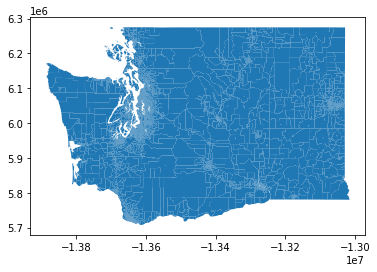

In [30]:
joined_demo_votes_col_order.append('geometry')
joined_demo_votes_shp = joined_demo_votes[joined_demo_votes_col_order]
display(joined_demo_votes_shp.head())
joined_demo_votes_shp.plot()

In [31]:
joined_demo_votes_shp.to_file('./wa_rpv_2020_precincts.shp')

C:\Users\SpencerNelson\AppData\Local\Temp\ipykernel_17152\4237787353.py:1: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  joined_demo_votes_shp.to_file('./wa_rpv_2020_precincts.shp')
